# Delay payments prediction model

**Scope of the the study is deployment of a model predicting customers payment delays**



In [16]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns


In [17]:
customer_base = pd.read_excel('customer_profile.xlsx', sheet_name='customers_profile_2021')

In [18]:
customer_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2487 entries, 0 to 2486
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CardCode            2487 non-null   object 
 1   CustomerRank        2487 non-null   int64  
 2   Domestic            2487 non-null   int64  
 3   Attika              2487 non-null   int64  
 4   Territory           2487 non-null   int64  
 5   U_GRSL              2483 non-null   float64
 6   U_ZeeKey2           2487 non-null   int64  
 7   SZSegmentation      2297 non-null   object 
 8   MarketSegmentation  2213 non-null   object 
 9   Subsegment          2399 non-null   object 
 10  SlpCode             2487 non-null   int64  
 11  AvgPayDays          2487 non-null   float64
 12  PaymentTerms        2487 non-null   int64  
 13  AvgLatePayDays      2487 non-null   int64  
 14  Tziros              2487 non-null   float64
 15  AvgSVal             2487 non-null   float64
 16  MaxSva

* Quick view of the features values

In [19]:
for column in customer_base.columns[2:-2]:
    print(f"############# START {column} #############")
    print(customer_base[column].value_counts())
    print(f"############# END {column} #############")

############# START Domestic #############
1    2472
0      15
Name: Domestic, dtype: int64
############# END Domestic #############
############# START Attika #############
1    1643
0     844
Name: Attika, dtype: int64
############# END Attika #############
############# START Territory #############
5      503
85     117
16     107
15     105
108     79
      ... 
156      1
93       1
126      1
145      1
130      1
Name: Territory, Length: 102, dtype: int64
############# END Territory #############
############# START U_GRSL #############
1.0     505
2.0     423
10.0    398
8.0     285
0.0     132
38.0     78
9.0      76
35.0     69
18.0     60
34.0     59
40.0     44
17.0     32
16.0     30
32.0     29
12.0     27
6.0      20
43.0     19
13.0     16
7.0      15
21.0     14
26.0     12
37.0     12
11.0     12
55.0     11
31.0     11
23.0     11
25.0      9
20.0      8
15.0      7
22.0      7
36.0      7
41.0      6
27.0      5
24.0      5
64.0      4
14.0      4
33.0      4
50.0 

In [20]:
customer_base.head()


,CardCode,CustomerRank,Domestic,Attika,Territory,U_GRSL,U_ZeeKey2,SZSegmentation,MarketSegmentation,Subsegment,SlpCode,AvgPayDays,PaymentTerms,AvgLatePayDays,Tziros,AvgSVal,MaxSval,invNo,AvgInvNoPerMonth,Basket
0,A.00001,7,0,1,130,0.0,5,NaN,NaN,NaN,64,0.00,210,-210,470640.83,21392.77,43385.5,22,2,"0119001004, 0018007003, 0127003001, 0026007003..."
1,A.00008,35,0,1,126,0.0,5,NaN,NaN,NaN,64,48.68,45,4,91826.00,15304.33,19551.0,6,1,"0094079001, 0025022020, 0094013002"
2,A.00023,43,0,1,134,0.0,4,NaN,NaN,NaN,64,117.00,62,55,68544.00,34272.00,36120.0,2,1,0005001010
3,A.00028,165,0,1,131,0.0,4,NaN,NaN,NaN,64,13.39,30,-17,14910.65,4970.22,5801.7,3,1,"0015035000, 0001026020, 0068001001, 0135000000..."
4,A.00032,2,0,1,123,0.0,4,NaN,NaN,NaN,64,26.97,1,26,1200310.47,25538.52,54926.6,47,3,"0015042001, 0095005001, 0026008002, 0025006010..."


* We create delay day buckets to make visualization of results better
* Then we remove the cases where payment days are negative (customers paying earlier than agreed!!)

In [21]:
customer_base['AvgLatePayDays_Buckets'] = customer_base['AvgLatePayDays'].apply(lambda days: days//30 * 30)
customer_base_filtered = customer_base[customer_base['AvgLatePayDays'] >= 0]

In [22]:
customer_base_filtered.head()

,CardCode,CustomerRank,Domestic,Attika,Territory,U_GRSL,U_ZeeKey2,SZSegmentation,MarketSegmentation,Subsegment,...,AvgPayDays,PaymentTerms,AvgLatePayDays,Tziros,AvgSVal,MaxSval,invNo,AvgInvNoPerMonth,Basket,AvgLatePayDays_Buckets
1,A.00008,35,0,1,126,0.0,5,NaN,NaN,NaN,...,48.68,45,4,91826.00,15304.33,19551.00,6,1,"0094079001, 0025022020, 0094013002",0
2,A.00023,43,0,1,134,0.0,4,NaN,NaN,NaN,...,117.00,62,55,68544.00,34272.00,36120.00,2,1,0005001010,30
4,A.00032,2,0,1,123,0.0,4,NaN,NaN,NaN,...,26.97,1,26,1200310.47,25538.52,54926.60,47,3,"0015042001, 0095005001, 0026008002, 0025006010...",0
5,A.00033,5,0,1,139,0.0,4,NaN,NaN,NaN,...,53.21,1,52,564752.17,26892.96,46480.50,21,1,"0015042001, 0025006010, 0015033000, 0026007002...",30
6,A.00035,11,0,1,120,0.0,4,NaN,NaN,NaN,...,63.66,62,2,257464.69,10727.70,27756.06,24,2,"0025006000, 0127010000, 0025017001, 0025006010...",0


array([[<AxesSubplot:title={'center':'AvgLatePayDays_Buckets'}>]],
      dtype=object)

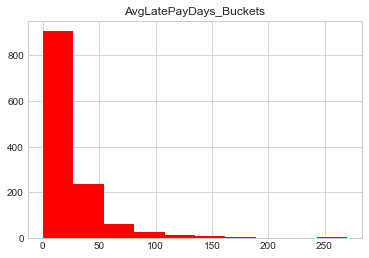

In [23]:
customer_base_filtered.hist(['AvgLatePayDays_Buckets'], color = "red")

In [24]:
customer_base_filtered.isnull().sum()

CardCode                    0
CustomerRank                0
Domestic                    0
Attika                      0
Territory                   0
U_GRSL                      0
U_ZeeKey2                   0
SZSegmentation             92
MarketSegmentation        128
Subsegment                 35
SlpCode                     0
AvgPayDays                  0
PaymentTerms                0
AvgLatePayDays              0
Tziros                      0
AvgSVal                     0
MaxSval                     0
invNo                       0
AvgInvNoPerMonth            0
Basket                      0
AvgLatePayDays_Buckets      0
dtype: int64

* Remove records with null values

In [25]:
customer_base_cleaned = customer_base_filtered.dropna()

In [26]:
customer_base_cleaned.isnull().sum()

CardCode                  0
CustomerRank              0
Domestic                  0
Attika                    0
Territory                 0
U_GRSL                    0
U_ZeeKey2                 0
SZSegmentation            0
MarketSegmentation        0
Subsegment                0
SlpCode                   0
AvgPayDays                0
PaymentTerms              0
AvgLatePayDays            0
Tziros                    0
AvgSVal                   0
MaxSval                   0
invNo                     0
AvgInvNoPerMonth          0
Basket                    0
AvgLatePayDays_Buckets    0
dtype: int64

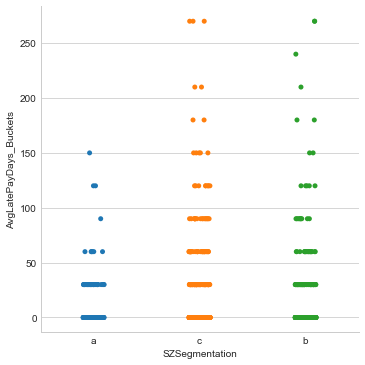

In [27]:
sns.catplot(x="SZSegmentation", y="AvgLatePayDays_Buckets", data=customer_base_filtered)

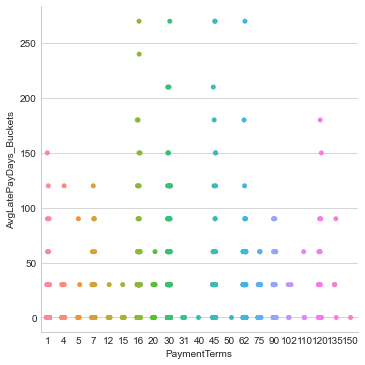

In [28]:
sns.catplot(x="PaymentTerms", y="AvgLatePayDays_Buckets", data=customer_base_filtered )

* Visualize possible correlation between delays in payments and customer characteristics

* Remove features wich assumed not be direclty connected the payment behavior of a customer

In [32]:
X = customer_base_cleaned.drop(['CardCode',"CustomerRank", "AvgLatePayDays_Buckets", "Domestic","Attika","Territory","U_GRSL","U_ZeeKey2","MarketSegmentation","Subsegment","SlpCode","AvgLatePayDays","AvgSVal", "MaxSval", "AvgInvNoPerMonth","AvgPayDays", "Basket"], axis =1)
y = customer_base_cleaned['AvgLatePayDays_Buckets']

In [33]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1137 entries, 9 to 2484
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SZSegmentation  1137 non-null   object 
 1   PaymentTerms    1137 non-null   int64  
 2   Tziros          1137 non-null   float64
 3   invNo           1137 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 44.4+ KB


In [34]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
str_columns = [column for column in X.columns if customer_base_cleaned[column].dtype == 'object']
X[str_columns] = enc.fit_transform(X[str_columns])

* We built a DecisionTreeClassifier model 

In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
cross_val_score(clf, X,y)

C:\Users\netadmin\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


array([0.53947368, 0.54385965, 0.52422907, 0.55066079, 0.50220264])

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)
clf.fit(X_train,y_train)

DecisionTreeClassifier(random_state=0)

In [37]:
clf.predict(X_test)

array([  0, 150,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,  60,   0,  30,   0,   0,   0,   0,  90,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        30,  30,   0,   0,  90,  30,  30,  30,   0,   0,   0,  60,   0,
         0,   0,  30,   0,   0,   0,  30,   0,  30,  30, 150,   0,   0,
        30,  30,   0,   0,  60,   0,   0,   0,   0,   0,   0,   0,  30,
         0,  60,   0,   0,  30,   0,  60,  30,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  60,  60,   0,  30,   0,   0,
         0,   0,  30,   0,   0,  30,   0,   0,   0,  90,   0,   0,   0,
         0,   0,   0,  30,   0,   0,   0,   0,   0,   0,   0,   0,  30,
         0,   0,   0,   0,   0,   0,  30,  30,   0,   0,   0,   0,   0,
         0,   0,   0,  90,   0,  30,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0, 180,  30,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  90,   0,  30,  30,   0,   0,   

In [38]:
from sklearn.metrics import zero_one_loss
from sklearn.metrics import accuracy_score
print("Accuracy score=" ,accuracy_score(y_test, clf.predict(X_test)))
print("Training error =", zero_one_loss(y_test, clf.predict(X_test)))

Accuracy score= 0.5578947368421052
Training error = 0.4421052631578948


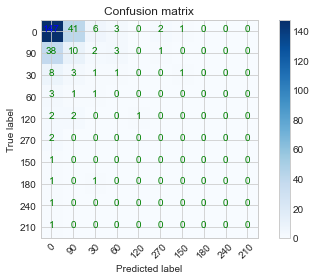

In [39]:
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="blue" if cm[i, j] > thresh else "green")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()  
    plt.show()

cm = confusion_matrix(y_test, clf.predict(X_test))

plot_confusion_matrix(cm, y.unique())

In [40]:
cm

array([[147,  41,   6,   3,   0,   2,   1,   0,   0,   0],
       [ 38,  10,   2,   3,   0,   1,   0,   0,   0,   0],
       [  8,   3,   1,   1,   0,   0,   1,   0,   0,   0],
       [  3,   1,   1,   0,   0,   0,   0,   0,   0,   0],
       [  2,   2,   0,   0,   1,   0,   0,   0,   0,   0],
       [  2,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,   1,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0,   0,   0,   0,   0]], dtype=int64)

**We bring togheter predictions of the DT model and actual bucket of days**

In [41]:
result = X.copy()

In [42]:
result['prediction_decission_tree'] = clf.predict(X)
result['AvgLatePayDays_Buckets'] = y

In [43]:
result.head()

,SZSegmentation,PaymentTerms,Tziros,invNo,prediction_decission_tree,AvgLatePayDays_Buckets
9,0.0,45,5660.52,44,0,0
11,2.0,16,376.68,4,90,90
12,2.0,16,330.08,3,0,0
13,2.0,45,480.40,4,30,30
15,2.0,16,177.45,2,0,0


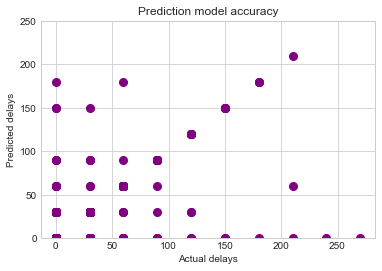

In [44]:
x = result["AvgLatePayDays_Buckets"]
y = result["prediction_decission_tree"]
plt.plot(x,y, 'o', color='purple',markersize=8)
plt.xlabel("Actual delays")
plt.ylabel("Predicted delays")
plt.title("Prediction model accuracy")
plt.ylim(0,250) 
plt.savefig('accuracy_dt.png')

* We notice a strong accuracy prediction ratio when days are less than 150. For days more than 150 , model seems inadequate

### Prediction with neural network

In [ ]:
from sklearn.neural_network import MLPClassifier
clf_nn = MLPClassifier(hidden_layer_sizes=(100,100,100,100,100))
cross_val_score(clf_nn, X,y)

In [ ]:
clf_nn.fit(X_train,y_train)

In [ ]:
from sklearn.metrics import zero_one_loss

print("Training error =", zero_one_loss(y_train, clf_nn.predict(X_train)))

In [ ]:
from sklearn.metrics import accuracy_score
print("Accurace score=" ,accuracy_score(y_train, clf_nn.predict(X_train)))


In [ ]:
cm_nn = confusion_matrix(y_test, clf_nn.predict(X_test))
cm_nn

In [ ]:
result['prediction_nn'] = clf_nn.predict(X)
result.tail(10)

In [ ]:
x = result["AvgLatePayDays_Buckets"]
z = result["prediction_nn"]
plt.plot(x,z, 'o', color='blue',markersize=8)
plt.xlabel("Actual delays")
plt.ylabel("Predicted delays")
plt.title("Prediction NN model accuracy")
plt.ylim(0,250) 
plt.savefig('accuracy_nn.png')

### Prediction with Linear suppor vector machine model

In [ ]:
from sklearn.svm import LinearSVC
clf_svm = LinearSVC()
cross_val_score(clf_svm, X_train, y_train)

**Results of this model are poor. So this method will not be included in any further analysis**

In [ ]:
#pip install openpyxl

In [ ]:
# Write the predicions to an excel file
result.to_excel("predictions.xlsx",sheet_name='Sheet_name_1') 

#### Author : Dimitris Mantaos